
#Modelling the Financial Crisis using RN/LSTMs

Based on Xavier et al. 's implementation, available at:

https://medium.com/neuronio/predicting-stock-prices-with-lstm-349f5a0974d4

Main tutorial available here:

https://medium.com/gradientcrescent/foreseeing-armageddon-could-ai-have-predicted-the-financial-crisis-1a44ca62b4f5


'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#GS dataset, insert download link

!gdown _______________________________ 

df = pd.read_csv("GS_new.csv")
print(df.head())
df['DateD'] = pd.to_datetime(df['Date'], format ='%d/%m/%Y')
df.set_index('DateD', inplace=True)

df = df['MA10']
#df= df[253:]

print(df)

Downloading...
From: https://drive.google.com/uc?id=18tnJwEZB2g2458pVXRC_evIzF8PoO9iK
To: /content/GS_new.csv
100% 137k/137k [00:00<00:00, 52.8MB/s]
         Date    Open    High     Low   Close   Volume   MA10
0  03/01/2006  126.70  129.44  124.23  128.87  6188700  128.0
1  04/01/2006  127.35  128.91  126.38  127.09  4862000  128.0
2  05/01/2006  126.00  127.32  125.61  127.04  3717600  128.0
3  06/01/2006  127.29  129.25  127.29  128.84  4319600  128.0
4  09/01/2006  128.50  130.62  128.00  130.39  4723500  128.0
DateD
2006-01-03    128.000
2006-01-04    128.000
2006-01-05    128.000
2006-01-06    128.000
2006-01-09    128.000
2006-01-10    128.000
2006-01-11    128.000
2006-01-12    128.000
2006-01-13    128.000
2006-01-17    130.433
2006-01-18    130.731
2006-01-19    131.404
2006-01-20    131.844
2006-01-23    132.247
2006-01-24    132.508
2006-01-25    132.661
2006-01-26    133.204
2006-01-27    133.873
2006-01-30    134.534
2006-01-31    135.400
2006-02-01    136.386
2006-02-02 

(2517,)


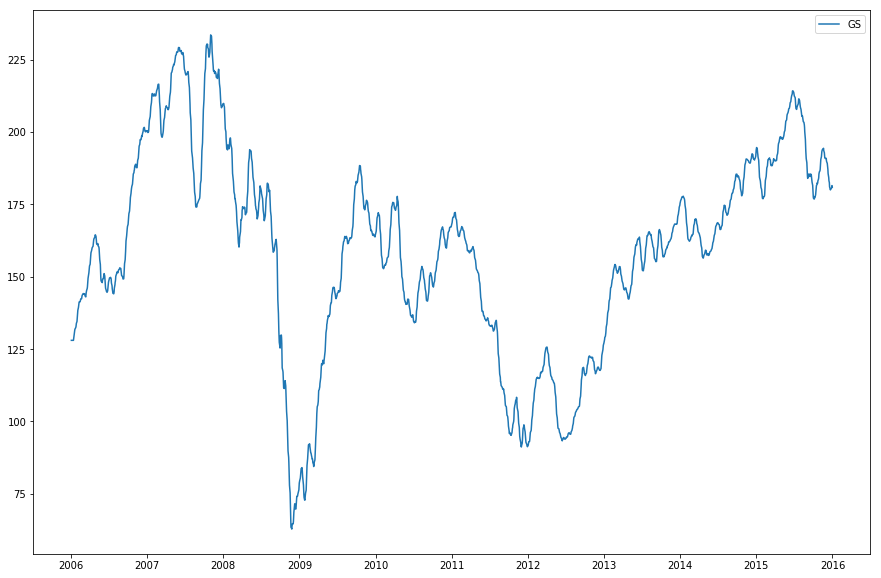

In [0]:
print(df.shape)
"""
View Data
"""

plt.figure(figsize = (15,10))
plt.plot(df, label='GS')
plt.legend(loc='best')
plt.show()

In [0]:
#Scaling data

from sklearn.preprocessing import MinMaxScaler

array = df.values.reshape(df.shape[0],1)
sc = MinMaxScaler()
array = sc.fit_transform(array)

#2517 rows, let's see if we can predict this using data pre 2007 ONLY, could we have predicted whats going to happen??

array[:10]



array([[0.38194392],
       [0.38194392],
       [0.38194392],
       [0.38194392],
       [0.38194392],
       [0.38194392],
       [0.38194392],
       [0.38194392],
       [0.38194392],
       [0.3961904 ]])

Re-shaping data into 20step timesequences, across all feature dimensions.

Why 20 step? we wanted to increase reactivity

In [0]:

look_back = 80 #How much history do we use? We start with 40 days, then try 80 and maybe 20
forward_days = 50 #how many days we predict forward? Try 10, 30, and 60 as a case in point
num_periods = 25 #How many prediction periods are there that we use


#Train test splitting, single CSV source
#Test set will be the last k (num_periods) periods we want test the model

#Length Dataset is 2518
#Length Datafset from jan 2007 is 2267

#Dec 29 2006 is 252 index, so we need to reach this
#July 02 2007 is 377 index
#fOR JANUARY 2007 WE MADE new file, index 506 is jan 2009
#For euro crisis, 3rd Jan 2011 is 1261 index

division = len(array) - num_periods*forward_days
#For fowrard 30 this is 2518 - 30*75 =268
#For 2007 to 2009 January ths is 2267 - 1750 =517
#jAN 2014 is 2015 index

array_test = array[division-look_back:]
array_train = array[:division]


#Batch data creator
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.

def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

  #Ravel converts 1D tuples into a single big ass array?? investigate further
  
X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

print(y_test)

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

#Finally lets split the leftover train set into validation as well

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.15, random_state=42)

#Sanity Check

print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)



[[0.63581002 0.6398152  0.64076965 ... 0.56185479 0.561644   0.56005715]
 [0.55890947 0.55962384 0.56237008 ... 0.43168071 0.43104246 0.42937363]
 [0.42659226 0.42500542 0.42480633 ... 0.34631307 0.33790454 0.32922081]
 ...
 [0.8420766  0.84311303 0.84480527 ... 0.83772009 0.83543059 0.83598686]
 [0.83332845 0.82998495 0.82620228 ... 0.69483953 0.69779071 0.70082973]
 [0.69934828 0.70080631 0.70450114 ... 0.69503276 0.69503276 0.69153116]]
(967, 80, 1)
(171, 80, 1)
(25, 80, 1)
(967, 50)
(171, 50)
(25, 50)


In [0]:



#Build the model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (look_back, 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 100))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, return_sequences = True))
#regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50))
#regressor.add(Dropout(0.2))

regressor.add(Dense(forward_days))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = regressor.fit(X_train,y_train,epochs=50,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 967 samples, validate on 171 samples
Epoch 1/50
 - 47s - loss: 0.0360 - val_loss: 0.0256
Epoch 2/50
 - 44s - loss: 0.0197 - val_loss: 0.0130
Epoch 3/50
 - 44s - loss: 0.0168 - val_loss: 0.0151
Epoch 4/50
 - 44s - loss: 0.0150 - val_loss: 0.0150
Epoch 5/50
 - 44s - loss: 0.0146 - val_loss: 0.0113
Epoch 6/50
 - 44s - loss: 0.0136 - val_loss: 0.0202
Epoch 7/50
 - 44s - loss: 0.0137 - val_loss: 0.0152
Epoch 8/50
 - 44s - loss: 0.0138 - val_loss: 0.0133
Epoch 9/50
 - 44s - loss: 0.0137 - val_loss: 0.0137
Epoch 10/50
 - 44s - loss: 0.0124 - val_loss: 0.0126
Epoch 11/50
 - 44s - loss: 0.0127 - val_loss: 0.0124
Epoch 12/50
 - 44s - loss: 0.0129 - val_loss: 0.0126
Epoch 13/50
 - 44s - loss: 0.0125 - val_loss: 0.0109
Epoch 14/50
 - 44s - loss: 0.0126 - val_loss: 0.0108
Epoch 15/50
 - 44s - loss: 0.0125 - val_loss: 0.0107
Epoch 16/50
 - 44s - loss: 0.0125 - val_loss: 0.0119
Epoch 17/50
 - 44s - loss: 0.0122 - val_loss: 0.0107
Epoch 18/50
 - 44s - loss: 0.0122 - val_loss: 0.0137
Epoch 19/

Predictions

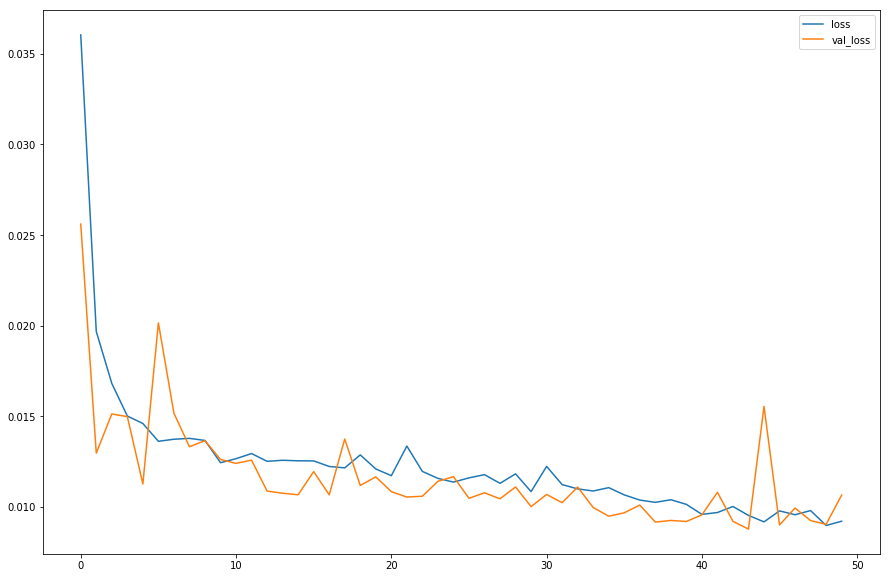

In [0]:
#View Results
plt.figure(figsize = (15,10))

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc='best')
plt.show()

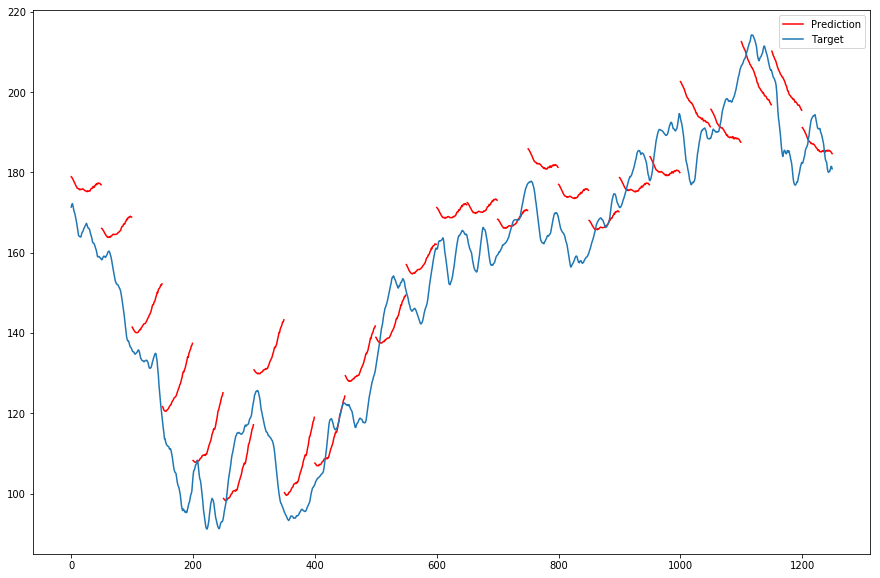

In [0]:
#Predict only

Xt = regressor.predict(X_test)

plt.figure(figsize = (15,10))

for i in range(0,len(Xt)):
    plt.plot([x + i*forward_days for x in range(len(Xt[i]))], sc.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    
plt.plot(0, sc.inverse_transform(Xt[i].reshape(-1,1))[0], color='r', label='Prediction') #only to place the label
    
plt.plot(sc.inverse_transform(y_test.reshape(-1,1)), label='Target')
plt.legend(loc='best')
plt.show()